In [1]:
import dataset
# from scipy.spatial import Delaunay
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from torch.autograd import Variable

np.random.seed(1)
torch.manual_seed(1)


In [2]:

def rotation_matrix_to_quaternion(M):
#   Note: M must have positive determinant.

    Q = torch.zeros(4)

    tr = M[0,0] + M[1,1] + M[2,2]
    if tr > 0.0: 
        s = 2.0 * math.sqrt(tr + 1.0)
        t = 1.0/s
        Q[0] = 0.25 * s
        Q[1] = (M[2,1] - M[1,2]) * t
        Q[2] = (M[0,2] - M[2,0]) * t
        Q[3] = (M[1,0] - M[0,1]) * t
    elif (M[0,0] > M[1,1]) and (M[0,0] > M[2,2]):
        s = 2.0 * math.sqrt(1.0 + M[0,0] - M[1,1] - M[2,2])
        t = 1.0/s
        Q[0] = (M[2,1] - M[1,2]) * t
        Q[1] = 0.25 * S
        Q[2] = (M[0,1] + M[1,0]) * t
        Q[3] = (M[0,2] + M[2,0]) * t
    elif M[1,1] > M[2,2]:
        s = 2.0 * math.sqrt(1.0 + M[1,1] - M[0,0] - M[2,2])
        t = 1.0/s
        Q[0] = (M[0,2] - M[2,0]) * t
        Q[1] = (M[0,1] + M[1,0]) * t
        Q[2] = 0.25 * s
        Q[3] = (M[1,2] + M[2,1]) * t
    else:
        s = 2.0 * math.sqrt(1.0 + M[2,2] - M[0,0] - M[1,1])
        t = 1.0/s
        Q[0] = (M[1,0] - M[0,1]) * t
        Q[1] = (M[0,2] + M[2,0]) * t
        Q[2] = (M[1,2] + M[2,1]) * t
        Q[3] = 0.25 * s
    
    return Q             

                 
def quaternion_to_rotation_matrix(Q):

    w = Q[0]
    x = Q[1]
    y = Q[2]
    z = Q[3]

    M = torch.zeros((3,3))
    
    M[0,0] = 1.0 - 2.0*(y*y + z*z)
    M[0,1] = 2.0*(x*y - w*z)
    M[0,2] = 2.0*(x*z + w*y)

    M[1,0] = 2.0*(x*y + w*z)
    M[1,1] = 1.0 - 2.0*(x*x + z*z)
    M[1,2] = 2.0*(y*z - w*x)

    M[2,0] = 2.0*(x*z - w*y)
    M[2,1] = 2.0*(y*z + w*x)
    M[2,2] = 1.0 - 2.0*(x*x + y*y)

    return M
                 
                 
def random_unit_quaternion():
                 
    Q = np.random.randn(4)
    norm = np.linalg.norm(Q)

    if norm > 1e-7:
        Q = Q/norm
    else:
        Q = np.array([1.0, 0.0, 0.0, 0.0])
        
    return torch.from_numpy(Q).float()
            
    

def random_rotation_matrix():
                 
    Q = random_unit_quaternion()        
    M = quaternion_to_rotation_matrix(Q)
                
    return M
                 

In [3]:
root = os.getcwd()

# choose dataset name from 'shapenetcorev2', 'shapenetpart', 'modelnet40' and 'modelnet10'
dataset_name = 'shapenetpart'

# choose split type from 'train', 'test', 'all', 'trainval' and 'val'
# only shapenetcorev2 and shapenetpart dataset support 'trainval' and 'val'
split = 'train'

d = dataset.Dataset(root=root, dataset_name=dataset_name, num_points=256, split=split, random_rotate=False)
print("datasize:", d.__len__())

item = 0
ps, lb, n, f = d[item]
print(ps.size(), ps.type(), lb.size(), lb.type(), n, f) 

# torch.save(ps, 'tensor.pt')
# ps = torch.load('tensor.pt')

datasize: 12137
torch.Size([256, 3]) torch.FloatTensor torch.Size([1]) torch.LongTensor airplane 02691156/points/d4d61a35e8b568fb7f1f82f6fc8747b8.pts


In [63]:
cloud = pv.PolyData(ps.numpy())
# cloud.plot()

volume = cloud.delaunay_3d(alpha=0.1)
shell = volume.extract_geometry().triangulate()
# shell.plot()


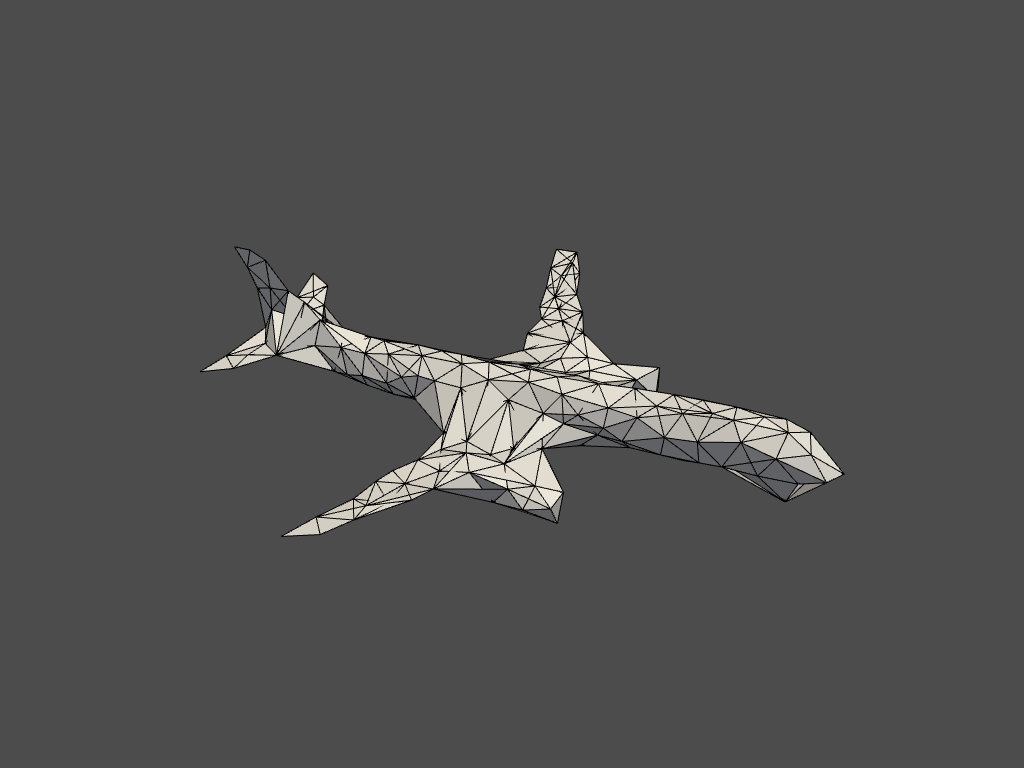

In [64]:
p = pv.Plotter()
p.add_mesh(shell, show_edges=True, color='white')
p.add_mesh(pv.PolyData(shell.points), color='red',
       point_size=1, render_points_as_spheres=True)
p.camera_position = [(2.02, 2.30, 2.73),
                 (0.02, 0.03, -0.022),
                 (-0.03, 0.94, -0.34)]
p.show()

In [195]:
np.arange(30)//3


array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
       7, 7, 8, 8, 8, 9, 9, 9], dtype=int32)

NameError: name 'tris' is not defined

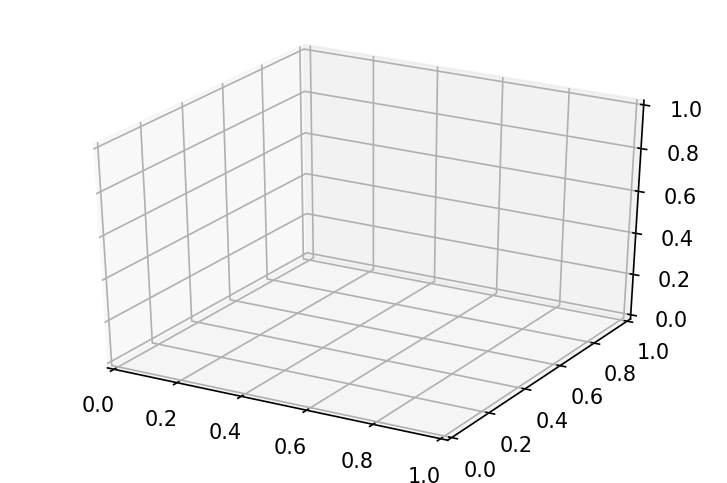

In [4]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

ntris = 100
i = np.random.randint(0, ps.shape[0], ntris)
xs = ps[tris[i,:],0]
ys = ps[tris[i,:],1]
zs = ps[tris[i,:],2]
cs = np.arange(3*ntris)//3
# print(i)
# print(tris[i,:])
# print(xs)
# print(ys)
# print(zs)

ax.scatter(xs, ys, zs, s=2.5, c=cs, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

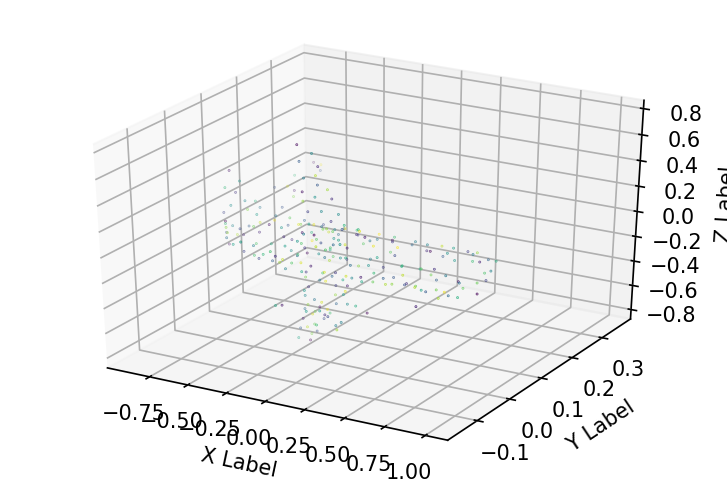

In [5]:
def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

#M = torch.from_numpy( random_rotation_matrix() ).float()
#ps = torch.mm(ps, M)

xs = ps[:,0]
ys = ps[:,1]
zs = ps[:,2]
cs = np.arange(ps.size()[0])
ax.scatter(xs, ys, zs, s=0.1, c=cs, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [8]:
class STN3dMaxPool(nn.Module):
    def __init__(self):
        super(STN3dMaxPool, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        return x


In [9]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.mp = STN3dMaxPool()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.relu = nn.ReLU()

        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = self.mp(x)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        x = x.view(-1, 4)
        
        return x


In [10]:
def training_loop(
    n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device, verbosity=None):

    for epoch in range(0, n_epochs):
        total_loss_train = 0.0
        n_batches_train = 0
        for x_train, y_train in train_loader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.train()
            if device is torch.device("cuda:0"):
                model.cuda()
            yhat_train = model(x_train)
            loss_train = loss_fn(y_train, yhat_train)
            total_loss_train += float(loss_train)
            n_batches_train += 1
            loss_train.backward()
            optimizer.step()
            optimizer.zero_grad()
             
        total_loss_val = 0.0
        n_batches_val = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                model.eval()
                yhat_val = model(x_val)
                loss_val = loss_fn(y_val, yhat_val)
                total_loss_val += float(loss_val)
                n_batches_val += 1
                
        if verbosity is not None and epoch % verbosity == 0:
            total_loss_train = total_loss_train/max(1,n_batches_train)
            total_loss_val = total_loss_val/max(1,n_batches_val)
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, total_loss_train, total_loss_val))
            
        

In [11]:
size_batch = 1000
x_tensor = torch.zeros((size_batch, 3, ps.shape[0]))
y_tensor = torch.zeros((size_batch, 4))

In [12]:
Q = torch.zeros(4)
Q[0] = 1.0

for i in range(0,x_tensor.shape[0]):
    M = quaternion_to_rotation_matrix(Q)
    x_tensor[i] = torch.mm(ps, M).reshape(ps.shape[1], ps.shape[0])
    y_tensor[i] = Q
    Q = random_unit_quaternion()
    

In [13]:
size_val = size_batch//5
size_train = size_batch - size_val

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [size_train, size_val])

train_loader = DataLoader(dataset=train_dataset, batch_size=min(16,size_train))
val_loader = DataLoader(dataset=val_dataset, batch_size=min(16,size_val))


In [14]:
def QuatRotLoss(y, yhat):
    loss = torch.mean( torch.min( ((y-yhat)**2).sum(dim=1), ((y+yhat)**2).sum(dim=1) ) )
    return loss

#model = SubclassFunctionalModel()
model = STN3d()
#optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# loss_fn = nn.MSELoss(reduction='mean')
loss_fn = QuatRotLoss
model, optimizer, loss_fn



(STN3d(
   (mp): STN3dMaxPool(
     (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
     (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
     (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
     (relu): ReLU()
     (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (fc1): Linear(in_features=1024, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=4, bias=True)
   (relu): ReLU()
   (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
  

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
training_loop(
    40, optimizer, model, loss_fn, train_loader, val_loader, device, 1)

Epoch 0, Training loss 0.7067647045850753, Validation loss 0.7426730348513677
Epoch 1, Training loss 0.35909717828035354, Validation loss 0.7169258411114032


KeyboardInterrupt: 

In [ ]:
A = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
# A*A
(A*A).sum(dim=1)
# B = A*A
# B, B.sum(axis=1)
# float(A.dot(A))
# torch.abs(torch.tensor([-1,2,3]))
# C = (1.0 - (A*-A).sum(axis=1).abs())
# torch.max(C, torch.tensor([1.0,2.0]))
# torch.max(torch.tensor([-1,3]), torch.tensor([1,2]))

In [ ]:
with torch.no_grad():
    Q = random_unit_quaternion()
    M = quaternion_to_rotation_matrix(Q)
    xt = torch.mm(ps, M).reshape(ps.shape[1], ps.shape[0])
    yt = Q
    model.eval()
    yhat = model(xt.unsqueeze(0)).squeeze_()   
    print(yt)
    print(yhat)
